# Install requirements

In [1]:
pip install pretty_midi crepe librosa mido pydub midi2audio python-rtmidi flask flask_cors

Note: you may need to restart the kernel to use updated packages.


# Detect and smoothen freqencies

In [2]:
import numpy as np
import librosa
from crepe import predict

def detect_frequency_with_filter(wav_file, threshold=0.72, step_size=10):
    # Perform frequency detection using CREPE
    audio, sr = librosa.load(wav_file, sr=None)
    print('extracted sample rate, audio. proceeding to detect frequency details...')
    
    time, frequency, confidence, _ = predict(audio, sr, step_size=step_size, viterbi=True)

    # Filter pitch based on confidence scores
    filtered_frequency = np.where(confidence >= threshold, frequency, np.nan)

    return time, filtered_frequency

def smoothen_detected_frequencies(detected_frequency):
    # Input data
    data = detected_frequency
    
    # Grouping algorithm
    time = data['time']
    frequencies = data['filtered_frequency']
    grouped_frequencies = frequencies.copy()
    
    # Initialize variables
    group_start = 0
    
    for i in range(1, len(time)):
        if (
            not np.isnan(frequencies[i])
            and not np.isnan(frequencies[group_start])
            and abs(frequencies[i] - frequencies[group_start]) <= 50
        ):
            # Same group
            continue
        else:
            # New group, calculate average of current group
            valid_frequencies = frequencies[group_start:i]
            if len(valid_frequencies[~np.isnan(valid_frequencies)]) > 0:
                group_avg = np.nanmean(valid_frequencies)
                grouped_frequencies[group_start:i] = group_avg
            group_start = i
    
    # Final group
    valid_frequencies = frequencies[group_start:]
    if len(valid_frequencies[~np.isnan(valid_frequencies)]) > 0:
        group_avg = np.nanmean(valid_frequencies)
        grouped_frequencies[group_start:] = group_avg
    
    # Update the object with grouped frequencies
    data['filtered_frequency'] = grouped_frequencies
    
    return data


# Construct midi File

In [3]:
from mido import MidiFile, MidiTrack, Message

def construct_midi_file_for_predicted_frequencies(smoothened_detected_frequency, wav_file, instrument_code, instrument_name):
    time_data = smoothened_detected_frequency['time']
    frequencies = smoothened_detected_frequency['filtered_frequency']
    
    # MIDI conversion: Frequency to MIDI Note number
    def frequency_to_midi(frequency):
        if np.isnan(frequency):
            return 0  # No note for NaN frequency
        return int(np.round(69 + 12 * np.log2(frequency / 440.0)))

    # Identify note start and end times
    events = []
    start_time = time_data[0]
    current_frequency = None
    
    for t, freq in zip(time_data, frequencies):
        midi_note = frequency_to_midi(freq)
        
        if midi_note != current_frequency:
            if current_frequency is not None:
                # End the current note
                events.append(('note_off', current_frequency, t - start_time))
            
            if midi_note != 0:  # Start a new note if it's not silence
                events.append(('note_on', midi_note, t - start_time))
            
            current_frequency = midi_note
    
    # Build MIDI file
    midi = MidiFile()
    track = MidiTrack()
    midi.tracks.append(track)
    
     # Set the instrument program (instrument_code)
    track.append(Message('program_change', program=instrument_code, time=0))
    
    # Track time for calculating delta times
    previous_time = 0
    
    for msg in events:
        delta_time = int((msg[2] - previous_time) * 1000)  # Convert time to milliseconds
        previous_time = msg[2]
        
        if msg[1] != 0 or msg[1] == 0:  # Skip silent notes (MIDI note 0)
            if msg[0] == 'note_on':
                track.append(Message('note_on', note=msg[1], velocity=127, time=delta_time))
            elif msg[0] == 'note_off':
                track.append(Message('note_off', note=msg[1], velocity=127, time=delta_time))
    
    # Save the MIDI file
    file_name = f"./generated_midi_files/{instrument_name}/generated_music_" +  os.path.basename(wav_file).replace(".wav", ".mid")
    midi.save(file_name)
    # print(f"Generated file: {file_name}")
    
    return file_name

## Convert midi file to .wav file

In [4]:
import subprocess
import os

def construct_wav_file_from_midi(input_midi, instrument_name, output_dir):
    output_wav = f"{output_dir}/{instrument_name}/" + os.path.basename(input_midi).replace('.mid','.wav')
    
    soundfont_path = os.path.abspath("./FluidR3_GM.sf2")
    fluidsynth_path = r'C:\ProgramData\chocolatey\bin\fluidsynth.exe' 
    
    # Convert to absolute paths
    input_midi = os.path.abspath(input_midi)
    
    # Check if SoundFont and MIDI files exist
    if not os.path.exists(soundfont_path):
        print(f"Error: SoundFont file not found at {soundfont_path}")
        return
    if not os.path.exists(input_midi):
        print(f"Error: MIDI file not found at {input_midi}")
        return
    
    # Ensure the output directory exists
    output_dir = os.path.dirname(output_wav)
    if output_dir and not os.path.exists(output_dir):
        print(f"Creating directory: {output_dir}")
        os.makedirs(output_dir, exist_ok=True)

    try:
        # Build the FluidSynth command using the full path to the executable
        # Added the `-s` flag for silent mode and `-F` to specify output file
        command = f'"{fluidsynth_path}" -s "{soundfont_path}" -F "{output_wav}" "{input_midi}"'
        
        # Run the command via subprocess with shell=True and capture stderr and stdout
        print(f"Converting {input_midi} to {output_wav} using {soundfont_path}")
        result = subprocess.run(command, shell=True, check=True, capture_output=True, text=True)
#         print(result.stdout)  # Print the standard output from the process
        # print(f"Conversion complete! WAV file saved at: {output_wav}")
    except subprocess.CalledProcessError as e:
        print(f"Error during conversion: {e.stderr}")  # Print the standard error from the process
    except Exception as e:
        print(f"Unexpected error: {e}")
    return output_wav

# Mix user_hum.wav and midi.wav

In [5]:
from pydub import AudioSegment
import IPython.display as ipd

def mix_and_play_audio(wav_file_1, wav_file_2, instrument_name):
    output_file = f"./generated_mixed_music/{instrument_name}/" + os.path.basename(wav_file_1).replace('.mid','.wav')
    # print('inside mix and play')
    # Load the .wav files
    try:
        audio_1 = AudioSegment.from_wav(wav_file_1)
        sr1 = audio_1.frame_rate 
    except Exception as e:
        print(e)
    try:
        audio_2 = AudioSegment.from_wav(wav_file_2)
        sr2 = audio_2.frame_rate 
    except Exception as e:
        print(e)
    
    # print(sr1, sr2)
    # Increase volume of audio_2 by 50%
    audio_1 = audio_1 + (audio_1.dBFS * 0.2)  # Increase by 50% relative to current volume
    
    # Decrease volume of audio_1 by 60%
    audio_2 = audio_2 - (audio_2.dBFS * 0.35)  # Decrease by 60% relative to current volume

    # Make sure both audio files are the same length (pad with silence if needed)
    if len(audio_1) > len(audio_2):
        audio_2 = audio_2 + AudioSegment.silent(duration=len(audio_1) - len(audio_2))
    elif len(audio_1) < len(audio_2):
        audio_1 = audio_1 + AudioSegment.silent(duration=len(audio_2) - len(audio_1))
    
    # print('finished padding')
    # Overlay the two audio tracks (this will play them simultaneously)
    mixed_audio = audio_1.overlay(audio_2)

    # print('trying to save')
    # Export the mixed audio to a new .wav file
    mixed_audio.export(output_file, format="wav")
    print(f'saved combined music at {output_file}')
    
    # Play the generated audio file
    return output_file

# Controller to generate monophonic music

In [6]:
instruments = {
    0: "Acoustic_Grand_Piano",
    24: "Acoustic_Guitar",
    50: "SynthStrings_1",
    73: "Flute"
}
def Generate_monophonic_music(wav_file):
    # Perform pitch detection with confidence filtering
    time, filtered_frequency = detect_frequency_with_filter(wav_file, threshold=0.72)
    detected_frequency = {"time": time, "filtered_frequency": filtered_frequency}
    
    # Smoothen the detected frequencies
    smoothened_detected_frequency = smoothen_detected_frequencies(detected_frequency)
    
    response_data = {}
    
    for instrument_code, instrument_name in instruments.items():
        # Generate midi file
        midi_file = construct_midi_file_for_predicted_frequencies(smoothened_detected_frequency, wav_file, instrument_code, instrument_name)

        # Convert midi file to waveform format
        instrument_waveform = construct_wav_file_from_midi(midi_file, instrument_name, output_dir="./converted_to_wav_files")

        # Mix user hum and instrument music
        combined_music = mix_and_play_audio(wav_file, instrument_waveform, instrument_name)
        if len(combined_music) == 0 :
            combined_music = instrument_waveform
        
        response_data[instrument_name] = {
            'instrument': instrument_waveform,
            'combined': combined_music
        }
    
    return response_data, smoothened_detected_frequency

#### test / verify (unit test: generate monophonic music)

In [7]:
wav_file = './inputs/example.wav'
_, smoothened_detected_frequency = Generate_monophonic_music(wav_file)
smoothened_detected_frequency

extracted sample rate, audio. proceeding to detect frequency details...
56/56 [==============================] - 29s 522ms/step
Converting d:\acadamics\codes1010\Major_MUSIC\codes\fullstack_me\backend\generated_midi_files\Acoustic_Grand_Piano\generated_music_example.mid to ./converted_to_wav_files/Acoustic_Grand_Piano/generated_music_example.wav using d:\acadamics\codes1010\Major_MUSIC\codes\fullstack_me\backend\FluidR3_GM.sf2
saved combined music at ./generated_mixed_music/Acoustic_Grand_Piano/example.wav
Converting d:\acadamics\codes1010\Major_MUSIC\codes\fullstack_me\backend\generated_midi_files\Acoustic_Guitar\generated_music_example.mid to ./converted_to_wav_files/Acoustic_Guitar/generated_music_example.wav using d:\acadamics\codes1010\Major_MUSIC\codes\fullstack_me\backend\FluidR3_GM.sf2
saved combined music at ./generated_mixed_music/Acoustic_Guitar/example.wav
Converting d:\acadamics\codes1010\Major_MUSIC\codes\fullstack_me\backend\generated_midi_files\SynthStrings_1\generated_

{'time': array([0.000e+00, 1.000e-02, 2.000e-02, ..., 1.762e+01, 1.763e+01,
        1.764e+01]),
 'filtered_frequency': array([         nan,          nan,          nan, ..., 196.29338919,
        196.29338919,          nan])}

# Controller to generate polyphonic music (using CVAE)

In [8]:
from WrapperForCVAE import Wrapper
from MatrixToMidi import generate_midi_from_matrix

wrapper = Wrapper()
prime_piano = r"C:\Users\chint\Major_MUSIC\temporary_server\generated_polyphonic_music\midi\prime_piano"
prime_guitar = r"C:\Users\chint\Major_MUSIC\temporary_server\generated_polyphonic_music\midi\prime_guitar"

def Generate_polyphonic_music(smoothened_detected_frequency, file_name, num_of_required_samples=2):
   # origihal is in shape [300, 128] || converted from {freq, time}
   original_piano = wrapper.convert_smoothened_freq_to_matrix(smoothened_detected_frequency, 1) # piano 
   result_primary_piano= wrapper.interpolate(original_piano, num_of_required_samples)
   mixed_samples_piano = wrapper.overlay_original_with_new_gen_samples(original_piano, result_primary_piano["generated_samples"])
   # wrapper.plot_samples(mixed_samples_piano[:1])
   
   # origihal is in shape [300, 128] || converted from {freq, time}
   original_guitar = wrapper.convert_smoothened_freq_to_matrix(smoothened_detected_frequency, 2) # guitar 
   result_primary_guitar= wrapper.interpolate(original_guitar, num_of_required_samples)
   mixed_samples_guitar =wrapper.overlay_original_with_new_gen_samples(original_guitar, result_primary_guitar["generated_samples"])
   # wrapper.plot_samples(mixed_samples_guitar[-1:])
   
   mixed_samples = np.concatenate((mixed_samples_piano, mixed_samples_guitar))
   
   wrapper.plot_samples(mixed_samples)
   mixed_samples_wav_path = []
   for i, music in enumerate(mixed_samples[:num_of_required_samples]):
      midi_save_path = prime_piano + "/" + file_name + f"__{i}__" + ".mid"
      generate_midi_from_matrix(music, midi_save_path)
      wav_save_path = construct_wav_file_from_midi(midi_save_path, "prime_piano", "./generated_polyphonic_music/wav")
      mixed_samples_wav_path.append(wav_save_path)
   
   for i, music in enumerate(mixed_samples[num_of_required_samples:]):
      midi_save_path = prime_guitar + "/" + file_name + f"__{i}__" + ".mid"
      generate_midi_from_matrix(music, midi_save_path)
      wav_save_path = construct_wav_file_from_midi(midi_save_path, "prime_guitar", "./generated_polyphonic_music/wav")
      mixed_samples_wav_path.append(wav_save_path)
   
   return mixed_samples_wav_path

Model loaded successfully for inference!


#### test/ verify generate polyphonic music controller



Generating samples for condition (1, 1, 1, 1) (piano-guitar-bass)
Replicating conditions on cpu...
Generating random latent vectors...
Processing original sample...
Encoding original sample...
Interpolating original latent with random latents using SLERP...
Decoding interpolated latents...


Generating samples for condition (1, 1, 1, 1) (piano-guitar-bass)
Replicating conditions on cpu...
Generating random latent vectors...
Processing original sample...
Encoding original sample...
Interpolating original latent with random latents using SLERP...
Decoding interpolated latents...


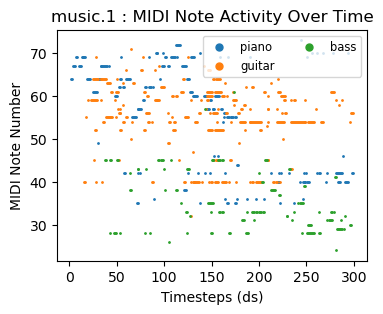

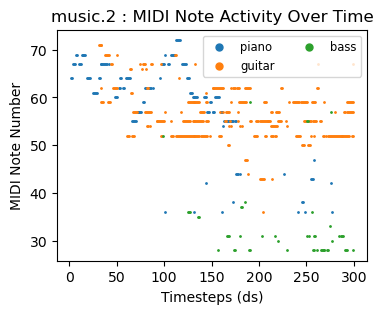

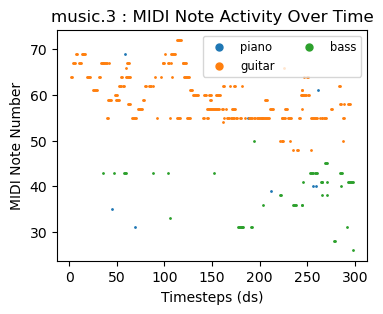

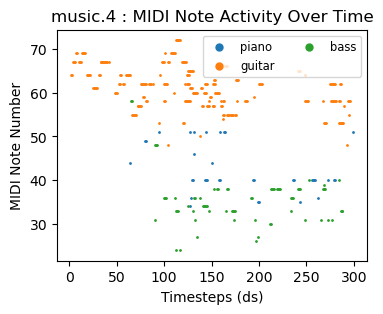

MIDI file saved at C:\Users\chint\Major_MUSIC\temporary_server\generated_polyphonic_music\midi\prime_piano/example__0__.mid
Converting C:\Users\chint\Major_MUSIC\temporary_server\generated_polyphonic_music\midi\prime_piano\example__0__.mid to ./generated_polyphonic_music/wav/prime_piano/example__0__.wav using d:\acadamics\codes1010\Major_MUSIC\codes\fullstack_me\backend\FluidR3_GM.sf2
MIDI file saved at C:\Users\chint\Major_MUSIC\temporary_server\generated_polyphonic_music\midi\prime_piano/example__1__.mid
Converting C:\Users\chint\Major_MUSIC\temporary_server\generated_polyphonic_music\midi\prime_piano\example__1__.mid to ./generated_polyphonic_music/wav/prime_piano/example__1__.wav using d:\acadamics\codes1010\Major_MUSIC\codes\fullstack_me\backend\FluidR3_GM.sf2
MIDI file saved at C:\Users\chint\Major_MUSIC\temporary_server\generated_polyphonic_music\midi\prime_guitar/example__0__.mid
Converting C:\Users\chint\Major_MUSIC\temporary_server\generated_polyphonic_music\midi\prime_guitar

In [9]:
# run monophonic test for this to work
file_name = os.path.basename(wav_file).replace(".wav", "")
mixed_samples_wav_path = Generate_polyphonic_music(smoothened_detected_frequency, file_name)
print(mixed_samples_wav_path)

# Server Code

In [10]:
from flask import Flask, request, send_file, jsonify
from flask_cors import CORS
import os
import time
from pydub import AudioSegment
from pydub.exceptions import CouldntDecodeError

app = Flask(__name__)
CORS(app)  # Enable CORS for all routes

# Ensure the input directory exists
os.makedirs("./inputs", exist_ok=True)

def convert_to_wav(input_path, output_path, target_sample_rate=44100):
    try:
        # Load the audio file
        audio = AudioSegment.from_file(input_path)

        # Convert sample rate to 44100 Hz
        if audio.frame_rate != target_sample_rate:
            audio = audio.set_frame_rate(target_sample_rate)

        # Export the resampled audio as WAV
        audio.export(output_path, format="wav")
        print(f"File converted to: {output_path} with sample rate {target_sample_rate} Hz")
        return True
    except CouldntDecodeError:
        print(f"Error: Could not decode the audio file.")
        return False
    except Exception as e:
        print(f"Error during conversion: {e}")
        return False

@app.route('/generate-music', methods=['POST'])
def generate_monophonic_music():
    # Check if a file is included in the request
    if 'audio' not in request.files:
        return jsonify({"error": "No audio file provided"}), 400
    
    file = request.files['audio']

    # Check if the file is valid
    if file.filename == '':
        return jsonify({"error": "Empty filename"}), 400

    # Check if the file is a WAV file based on MIME type
    if file.content_type != 'audio/wav':
        return jsonify({"error": "Invalid file type. Please upload a WAV file."}), 400
    
    # Save the uploaded file as a .wav file
    timestamp = int(time.time())  # Timestamp in seconds

    # Create a new filename by appending timestamp
    filename_with_timestamp = f"{timestamp}_{file.filename}"

    # Save the uploaded file with the new filename
    save_path = os.path.join("./inputs", filename_with_timestamp)
    file.save(save_path)
    print(f'File saved at {save_path}')
    
    # Convert the file to a proper WAV format with 44100 Hz sample rate
    output_path = os.path.join("./inputs", f"{timestamp}_converted.wav")
    if not convert_to_wav(save_path, output_path):
        return jsonify({"error": "Failed to convert the audio file to WAV format"}), 400
    
    file_name = os.path.basename(output_path).replace(".wav", "")

    # Return the files as response
    try:
        response_data, smoothened_detected_frequency = Generate_monophonic_music(output_path)
        polyphonic_music_data = Generate_polyphonic_music(smoothened_detected_frequency, file_name)
        response_data['polyphonic_music'] = polyphonic_music_data # array of file names
        return response_data
    except Exception as e:
        print("error processing current request")
        return jsonify({"error": str(e)}), 500

@app.route('/get-file', methods=['GET'])
def get_file():
    # Get the file location from the query parameter
    file_location = request.args.get('file_location')
    
    if not file_location:
        return jsonify({"error": "File location is required"}), 400
    
    # Check if the file exists
    if not os.path.exists(file_location):
        return jsonify({"error": "File not found"}), 404
    
    # Send the file back to the client
    try:
        return send_file(file_location, mimetype='audio/wav', as_attachment=True)
    except Exception as e:
        return jsonify({"error": str(e)}), 500

if __name__ == '__main__':
    app.run(debug=True, use_reloader=False)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


File saved at ./inputs\1739451580_audio.wav
File converted to: ./inputs\1739451580_converted.wav with sample rate 44100 Hz
extracted sample rate, audio. proceeding to detect frequency details...
24/24 [==============================] - 10s 397ms/step
Converting d:\acadamics\codes1010\Major_MUSIC\codes\fullstack_me\backend\generated_midi_files\Acoustic_Grand_Piano\generated_music_1739451580_converted.mid to ./converted_to_wav_files/Acoustic_Grand_Piano/generated_music_1739451580_converted.wav using d:\acadamics\codes1010\Major_MUSIC\codes\fullstack_me\backend\FluidR3_GM.sf2
saved combined music at ./generated_mixed_music/Acoustic_Grand_Piano/1739451580_converted.wav
Converting d:\acadamics\codes1010\Major_MUSIC\codes\fullstack_me\backend\generated_midi_files\Acoustic_Guitar\generated_music_1739451580_converted.mid to ./converted_to_wav_files/Acoustic_Guitar/generated_music_1739451580_converted.wav using d:\acadamics\codes1010\Major_MUSIC\codes\fullstack_me\backend\FluidR3_GM.sf2
saved c

127.0.0.1 - - [13/Feb/2025 18:29:59] "POST /generate-music HTTP/1.1" 200 -
127.0.0.1 - - [13/Feb/2025 18:29:59] "GET /get-file?file_location=./converted_to_wav_files/Acoustic_Grand_Piano/generated_music_1739451580_converted.wav HTTP/1.1" 200 -
127.0.0.1 - - [13/Feb/2025 18:29:59] "GET /get-file?file_location=./generated_polyphonic_music/wav/prime_guitar/1739451580_converted__1__.wav HTTP/1.1" 200 -
127.0.0.1 - - [13/Feb/2025 18:29:59] "GET /get-file?file_location=./generated_polyphonic_music/wav/prime_piano/1739451580_converted__1__.wav HTTP/1.1" 200 -
127.0.0.1 - - [13/Feb/2025 18:29:59] "GET /get-file?file_location=./generated_polyphonic_music/wav/prime_guitar/1739451580_converted__0__.wav HTTP/1.1" 200 -
127.0.0.1 - - [13/Feb/2025 18:29:59] "GET /get-file?file_location=./generated_polyphonic_music/wav/prime_piano/1739451580_converted__0__.wav HTTP/1.1" 200 -
127.0.0.1 - - [13/Feb/2025 18:30:00] "GET /get-file?file_location=./generated_mixed_music/Acoustic_Grand_Piano/1739451580_conv